In [4]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from textblob import TextBlob

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.pipeline import make_pipeline

import pandas as pd
import numpy as np
import re  
import matplotlib.pyplot as plt

import pyLDAvis
import pyLDAvis.gensim_models

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Angela\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Angela\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
import pandas as pd
vichy = pd.read_csv("tweets_vichy.csv")
vichy = vichy.drop(['Unnamed: 0', 'Date', 'User'], axis=1)

## Data Cleaning

In [6]:
vichy.head()

,Tweet
0,Vichy Mineral 89 Hyaluronic Acid Serum for Fac...
1,Vichy Showers are a great way to induce relaxa...
2,update: the vichy serum broke me out and i don...
3,"To de-stress the skin, you need to address its..."
4,Vichy up to -42% for super healthy skin ➡️ htt...


### Remove punctuation, special characters and lower casing

In [7]:
# 1 - Text cleaning
def clean_up(s):
    clean = re.sub(r'http\S+', '', s)
    return re.sub('[^A-Za-z ]+', ' ', clean).lower().strip()

def clean_up2(s):
    clean2 = re.sub(r'\W*\b\w{1,3}\b', '', s)
    return re.sub('[^A-Za-z ]+', ' ', clean2).lower().strip()

In [8]:
# In order to avoid errors, change type to string
vichy['Tweet'] = vichy['Tweet'].apply(str)  # change to string for avoiding errors

In [9]:
vichy['Tweet_Processed'] = vichy['Tweet'].apply(clean_up).apply(clean_up2)
vichy

,Tweet,Tweet_Processed
0,Vichy Mineral 89 Hyaluronic Acid Serum for Fac...,vichy mineral hyaluronic acid serum face hy...
1,Vichy Showers are a great way to induce relaxa...,vichy showers great induce relaxation other b...
2,update: the vichy serum broke me out and i don...,update vichy serum broke even have sensitive skin
3,"To de-stress the skin, you need to address its...",stress skin need address most essential needs ...
4,Vichy up to -42% for super healthy skin ➡️ htt...,vichy super healthy skin vichylaboratoires ...
...,...,...
1726,Sensitive skin requires extra hydration mornin...,sensitive skin requires extra hydration mornin...
1727,"The Vichy Mineral water: Awesome packaging, ni...",vichy mineral water awesome packaging nice f...
1728,@howthox You can try Vichy Nutrilogie 2- very ...,howthox vichy nutrilogie very skin
1729,@Mikkuchan07 Clinique and Vichy are the best b...,mikkuchan clinique vichy best more expensive ...


### Tokenize words and further clean-up text

In [10]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = vichy.Tweet_Processed.values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

C:\Users\Angela\ANACONDA\lib\site-packages\botocore\httpsession.py:41: DeprecationWarning: 'urllib3.contrib.pyopenssl' module is deprecated and will be removed in a future release of urllib3 2.x. Read more in this issue: https://github.com/urllib3/urllib3/issues/2680
  from urllib3.contrib.pyopenssl import orig_util_SSLContext as SSLContext


['vichy', 'mineral', 'hyaluronic', 'acid', 'serum', 'face', 'hydrating', 'face', 'serum', 'daily', 'face', 'moisturizer', 'women', 'with', 'natural', 'hyaluronic', 'acid', 'sensitive', 'skin', 'winter', 'skin', 'oily', 'skin']


### Phrase Modeling: Bigram and Trigram Models

In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

### Remove Stopwords, Make Bigrams and Lemmatize

In [12]:
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['SA', 'link', '$', 'ohmybeautybank'])

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Angela\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
#pip install spacy

In [14]:
!python -m spacy download en_core_web_sm
import spacy

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# print(data_lemmatized[:1][0][:30])

     ---------------------------------------- 12.8/12.8 MB 8.4 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


C:\Users\Angela\ANACONDA\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:18: DeprecationWarning: Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  DESCRIPTOR = _descriptor.FileDescriptor(
C:\Users\Angela\ANACONDA\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:36: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _descriptor.FieldDescriptor(
C:\Users\Angela\ANACONDA\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:43: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _descriptor.F

In [15]:
data_words_bigrams

[['vichy',
  'mineral',
  'hyaluronic_acid',
  'serum',
  'face',
  'hydrating',
  'face',
  'serum',
  'daily',
  'face',
  'moisturizer',
  'women',
  'natural',
  'hyaluronic_acid',
  'sensitive',
  'skin',
  'winter',
  'skin',
  'oily',
  'skin'],
 ['vichy',
  'showers',
  'great',
  'induce',
  'relaxation',
  'benefits',
  'include',
  'improved',
  'circulation',
  'improved',
  'metabolism',
  'helps',
  'promote',
  'sleep',
  'firms',
  'tones',
  'skin',
  'stimulates',
  'organ',
  'function',
  'loosens',
  'tight',
  'muscles',
  'relieves',
  'stress',
  'moana',
  'lani',
  'moanalanispa'],
 ['update', 'vichy', 'serum', 'broke', 'even', 'sensitive', 'skin'],
 ['stress',
  'skin',
  'need',
  'address',
  'essential',
  'needs',
  'prebiotic',
  'increases',
  'skin',
  'radiance',
  'improves',
  'texture',
  'reduces',
  'fine_lines',
  'weeks',
  'questions',
  'shop',
  'vichylover',
  'vichyusa',
  'mineral'],
 ['vichy',
  'super',
  'healthy',
  'skin',
  'vichyco

In [16]:
data_lemmatized

[['vichy',
  'mineral',
  'hyaluronic_acid',
  'serum',
  'face',
  'hydrate',
  'face',
  'daily',
  'face',
  'moisturizer',
  'woman',
  'natural',
  'hyaluronic_acid',
  'sensitive',
  'skin',
  'winter',
  'skin',
  'oily',
  'skin'],
 ['vichy',
  'shower',
  'great',
  'induce',
  'relaxation',
  'benefit',
  'include',
  'improve',
  'circulation',
  'improved',
  'metabolism',
  'help',
  'promote',
  'sleep',
  'firm',
  'tone',
  'skin',
  'stimulate',
  'organ',
  'function',
  'tight',
  'muscle',
  'relieve'],
 ['update', 'vichy', 'serum', 'break', 'even', 'sensitive', 'skin'],
 ['stress',
  'skin',
  'need',
  'address',
  'essential',
  'need',
  'prebiotic',
  'increase',
  'skin',
  'radiance',
  'improve',
  'texture',
  'reduce',
  'fine_line',
  'week',
  'question',
  'mineral'],
 ['super', 'healthy', 'skin', 'vichycommunity', 'skinpositivity'],
 ['bookgirlb',
  'thejenrollin',
  'skin',
  'weird',
  'never',
  'react',
  'product',
  'vichy',
  'moisturizer',
  's

### Data Transformation: Corpus and Dictionary

In [17]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

# It is creating a dictionary with the order of words and their frequency in the dataset
# For instance, if first word was able, it would indicate it appears 1 time in the dictionary

[(0, 1), (1, 3), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 3), (11, 1), (12, 1), (13, 1)]


### Base Model

In [18]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

### View the topics in LDA model

In [19]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.022*"skin" + 0.018*"hear" + 0.016*"prove" + 0.013*"look" + 0.013*"vichy" '
  '+ 0.012*"usually" + 0.012*"glow" + 0.011*"safe" + 0.011*"mattifying" + '
  '0.011*"even"'),
 (1,
  '0.049*"skin" + 0.044*"mask" + 0.026*"vichy" + 0.026*"roche_posay" + '
  '0.017*"acne" + 0.014*"face" + 0.012*"normaderm" + 0.012*"treatment" + '
  '0.011*"acid" + 0.010*"peel"'),
 (2,
  '0.084*"skin" + 0.044*"cream" + 0.040*"vichy" + 0.033*"face" + '
  '0.029*"moisturizer" + 0.021*"sensitive" + 0.019*"serum" + 0.018*"hydrate" + '
  '0.015*"hydration" + 0.015*"anti"'),
 (3,
  '0.052*"skin" + 0.044*"vichy" + 0.032*"skincare" + 0.017*"research" + '
  '0.015*"exposome" + 0.013*"ampoule" + 0.011*"dermatology" + 0.010*"beauty" + '
  '0.010*"antiage" + 0.010*"offer"'),
 (4,
  '0.046*"skin" + 0.021*"vichy" + 0.019*"break" + 0.018*"type" + 0.018*"love" '
  '+ 0.016*"good" + 0.014*"ampoule" + 0.014*"power" + 0.013*"make" + '
  '0.013*"tell"'),
 (5,
  '0.082*"skin" + 0.050*"vitamin" + 0.038*"serum" + 0.028*"age"

### Compute Model Perplexity and Coherence Score

In [20]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.37915669820432185


### Hyperparameter Tuning

In [21]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [22]:
coherence_model_lda

In [ ]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results_vichy.csv', index=False)
    pbar.close()

  0%|          | 0/540 [00:00<?, ?it/s]

In [24]:
result = pd.read_csv("lda_tuning_results_vichy.csv")
result

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,0.301729
1,75% Corpus,2,0.01,0.31,0.274778
2,75% Corpus,2,0.01,0.61,0.296837
3,75% Corpus,2,0.01,0.9099999999999999,0.289944
4,75% Corpus,2,0.01,symmetric,0.295794
...,...,...,...,...,...
535,100% Corpus,10,asymmetric,0.01,0.329839
536,100% Corpus,10,asymmetric,0.31,0.401554
537,100% Corpus,10,asymmetric,0.61,0.357226
538,100% Corpus,10,asymmetric,0.9099999999999999,0.333504


In [25]:
#calculate mean of points grouped by topics -- REVISAR
topics = result.groupby('Topics')['Coherence'].mean()
topics

Topics
2     0.314318
3     0.333212
4     0.328173
5     0.325792
6     0.330583
7     0.340873
8     0.340655
9     0.342993
10    0.360420
Name: Coherence, dtype: float64

In [26]:
# Generated by OPEN AI 
import pandas as pd

# Create a dictionary with the coherence values
coherence_dict = {'Topics': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'Coherence': [0.314318, 0.333212, 0.328173, 0.325792, 0.330583, 0.340873, 0.340655, 0.342993, 0.360420]}

# Create a pandas dataframe from the dictionary
coherence_df = pd.DataFrame(coherence_dict)

# Print the dataframe
coherence_df

,Topics,Coherence
0,2,0.314318
1,3,0.333212
2,4,0.328173
3,5,0.325792
4,6,0.330583
5,7,0.340873
6,8,0.340655
7,9,0.342993
8,10,0.360420


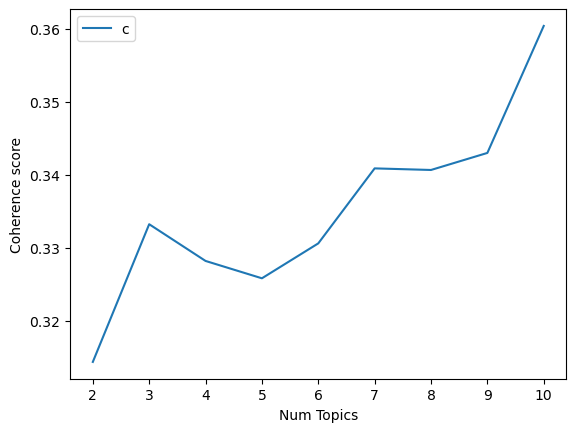

In [27]:
# Show graph -- fix it!
limit=40; start=2; step=6;
x = coherence_df['Topics']
y = coherence_df['Coherence']
plt.plot(x, y)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

## Final Model

In [28]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto')

In [29]:
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds = "mmds", R=30)
vis

C:\Users\Angela\ANACONDA\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.185076 -0.394821       1        1  48.120695
2     -0.160700 -0.391381       2        1  18.487333
9     -0.370429 -0.027463       3        1   6.329707
3     -0.232418  0.300506       4        1   6.329594
5      0.301491 -0.086708       5        1   5.743584
6      0.326095  0.190670       6        1   5.662817
7      0.047998  0.292546       7        1   2.873794
4     -0.102085 -0.078036       8        1   2.520532
0     -0.084463  0.103813       9        1   2.117673
1      0.089435  0.090874      10        1   1.814271, topic_info=                  Term         Freq        Total Category  logprob  loglift
10                skin  2124.000000  2124.000000  Default  30.0000  30.0000
11               vichy  1040.000000  1040.000000  Default  29.0000  29.0000
9                serum   245.000000   245.000000  Default  28.0000  28.0000
67               cream   236.000000   236.000000  Default  27.0000  27.0000
293           skincare   171.000000   171.000000  Default  26.0000  26.0000
...                ...          ...          ...      ...      ...      ...
2432  christophe_robin     1.979001     2.716097  Topic10  -5.3940   3.6929
3028             covid     1.905499     2.642809  Topic10  -5.4319   3.6824
3046          sitewide     1.900525     2.637929  Topic10  -5.4345   3.6816
1231              city     1.842404     2.579540  Topic10  -5.4655   3.6729
2433       dermadoctor     1.790370     2.527444  Topic10  -5.4942   3.6647

[348 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
123      10  0.985659      acid
54        5  0.983761      acne
375       5  0.906261  actually
1190      7  0.848078       add
3467     10  0.855772  additive
...     ...       ...       ...
466       1  0.993110      well
13        2  0.971799     woman
401       1  0.995348      work
551       2  0.978298   wrinkle
301       3  0.979304      year

[325 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 3, 10, 4, 6, 7, 8, 5, 1, 2])

In [30]:
pyLDAvis.save_html(vis, 'lda_visualization_vichy.html')